<a href="https://colab.research.google.com/github/Lique0/Detec-o_Facial/blob/main/Detec%C3%A7%C3%A3o_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo principal deste projeto é trabalhar com as bibliotecas e frameworks estudados e analisados em nossas aulas. Neste sentido, a proposta padrão envolve um sistema de detecção e reconhecimento de faces, utilizando as bibliotecas que o projetista julgue necessárias, de forma ilimitada.  

Para a realizaçã deste Projeto foram utilizadas as contribuições apresentadas a seguir:

--> https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=buJCl90WhNfq

--> https://colab.research.google.com/drive/13vgWfO1K87yCKgF-GKxXXuVTJr4l9fjf

--> https://github.com/diegobrunoDIO/Deteccao-de-faces-OpenCV-ResNet/blob/main/Face-detection-OpenCV%2BResNet.py

Trabalho proposto pelo curso de Machine Learning da DIO.

Importando todas as bibliotecas necessárias para a execução correta do projeto.

In [11]:
import imutils #redimencionamento, rotacao
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js

from base64 import b64decode

Para a inicialização da da webcam e captura de frame foi utilizada a função com o auxilio do Opencv2 apresentada a seguir.


In [12]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


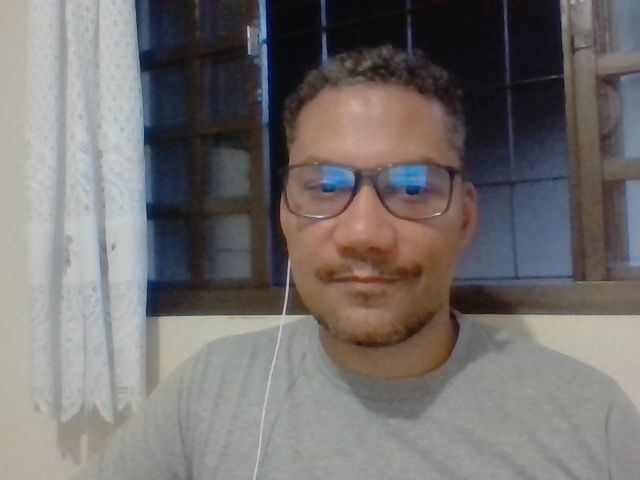

In [13]:
from IPython.display import Image
try:
  captura = take_photo()
  print('Saved to {}'.format(captura))

  # Show the image which was just taken.
  display(Image(captura))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Para a leitura, redimensão e exibição da imagem foi utilizado o código a seguir:

400 300


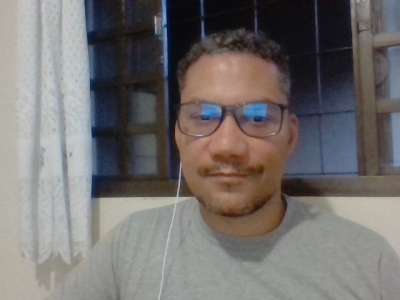

In [14]:
image = cv2.imread(captura)

# redimensiona para ter uma largura máxima de 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Para a detecção facial foi utilizado o mesmo utiliado no curso da DIO fornecido atraves do GIthub do professor Diego Bruno, que será apresentado a seguir:

"O detector de face em Deep Learning do OpenCV é baseado na estrutura Single Shot Detector (SSD) com uma rede base ResNet. A rede é definida e treinada usando o Caffe Deep Learning framework"

Baixe o modelo de detecção de rosto pré-treinado (2 arquivos):

- definição de rede (deploy.prototxt)
- pesos aprendidos (res10_300x300_ssd_iter_140000.caffemodel)

In [15]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-02-01 22:09:46--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2025-02-01 22:09:46 (16.3 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-02-01 22:09:46--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [16]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


Carregando o modelo de rede de detecção facial.

In [17]:
# redimensiona para ter uma largura máxima de 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [18]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Redimensionando a imagem para 300x300 pixels fixos e realizando a normalização.

In [19]:
for i in range(0, detections.shape[2]):

	# extrair a probabilidade associada à previsão
	confidence = detections[0, 0, i, 2]

	# filtra detecções fracas garantindo que a "confiança" seja
	# maior que o limite mínimo de confiança
	if confidence > 0.5: #Nossa detecção deve ter no mínimo 50% de certeza
		# calcula as coordenadas (x, y) da caixa delimitadora do objeto
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# desenha a caixa delimitadora da face junto com a probabilidade associada
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Loop para as detecções e criação do desenho das caixas ao redor de todos os rostos que forem detectados.

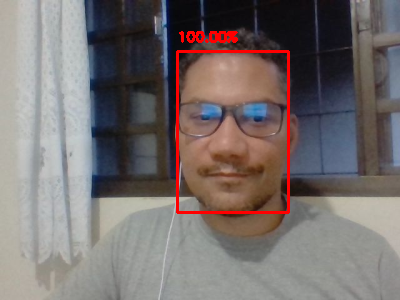

In [20]:
cv2_imshow(image)